In [5]:
import sys

# Install PyTorch with CUDA 11.8
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install all other packages
!{sys.executable} -m pip install \
  numpy matplotlib pillow \
  opencv-python \
  pycocotools \
  albumentations \
  scikit-image \
  pandas

# Automatically restart the kernel
# display(Javascript("Jupyter.notebook.kernel.restart()"))


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /usr/local/bin/python3.9 -m pip install --upgrade pip


In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [6]:
import os
import gc
import json
import random
import cv2
import torch
torch.cuda.empty_cache()
import torchvision

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

from PIL import Image
from collections import Counter

import torch.optim as optim
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10551d910>>
Traceback (most recent call last):
  File "/Users/siva_tarun/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [1]:
# 1. User parameters
dataset_dir    = 'data'                  # ← change this
INPUT_FILE     = 'data/annotations.json'  # ← your single annotations file
TEST_PCT       = 0.10                    # 10% test
VAL_PCT        = 0.10                    # 10% val
RANDOM_SEED    = 42                      # for reproducibility

# 2. Load the full annotation JSON
with open(os.path.join(dataset_dir, INPUT_FILE), 'r') as f:
    full = json.load(f)

images            = full['images']
annotations       = full.get('annotations', [])
scene_annotations = full.get('scene_annotations', [])
info              = full.get('info', None)
licenses          = full.get('licenses', [])
categories        = full.get('categories', [])
scene_categories  = full.get('scene_categories', [])

# 3. Shuffle & split image list
random.seed(RANDOM_SEED)
random.shuffle(images)
N = len(images)
n_test = int(N * TEST_PCT + 0.5)
n_val  = int(N * VAL_PCT  + 0.5)

test_images  = images[:n_test]
val_images   = images[n_test:n_test+n_val]
train_images = images[n_test+n_val:]

# 4. Build index sets for fast lookup
test_ids  = {img['id'] for img in test_images}
val_ids   = {img['id'] for img in val_images}
train_ids = {img['id'] for img in train_images}

# 5. Partition annotations
def split_anns(anns, idset):
    return [a for a in anns if a['image_id'] in idset]

train_anns        = split_anns(annotations,       train_ids)
val_anns          = split_anns(annotations,       val_ids)
test_anns         = split_anns(annotations,       test_ids)
train_scene_anns  = split_anns(scene_annotations, train_ids)
val_scene_anns    = split_anns(scene_annotations, val_ids)
test_scene_anns   = split_anns(scene_annotations, test_ids)

# 6. Helper to dump one subset
def dump_subset(name, imgs, anns, scene_anns):
    out = {
        'info':             info,
        'licenses':         licenses,
        'categories':       categories,
        'scene_categories': scene_categories,
        'images':           imgs,
        'annotations':      anns,
        'scene_annotations': scene_anns,
    }
    path = os.path.join(dataset_dir, f'annotations_{name}.json')
    with open(path, 'w') as f:
        json.dump(out, f)
    print(f'Wrote {name}: {len(imgs)} images, {len(anns)} masks')

Wrote train: 1200 images, 3812 masks
Wrote val: 150 images, 487 masks
Wrote test: 150 images, 485 masks


In [ ]:
# 7. Write three files
dump_subset('train', train_images, train_anns, train_scene_anns)
dump_subset('val',   val_images,   val_anns,   val_scene_anns)
dump_subset('test',  test_images,  test_anns,  test_scene_anns)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!

Image 1012 (batch_5/000113.JPG) has 2 masks:
  • Meal carton (super: Carton)
  • Plastic film (super: Plastic bag & wrapper)


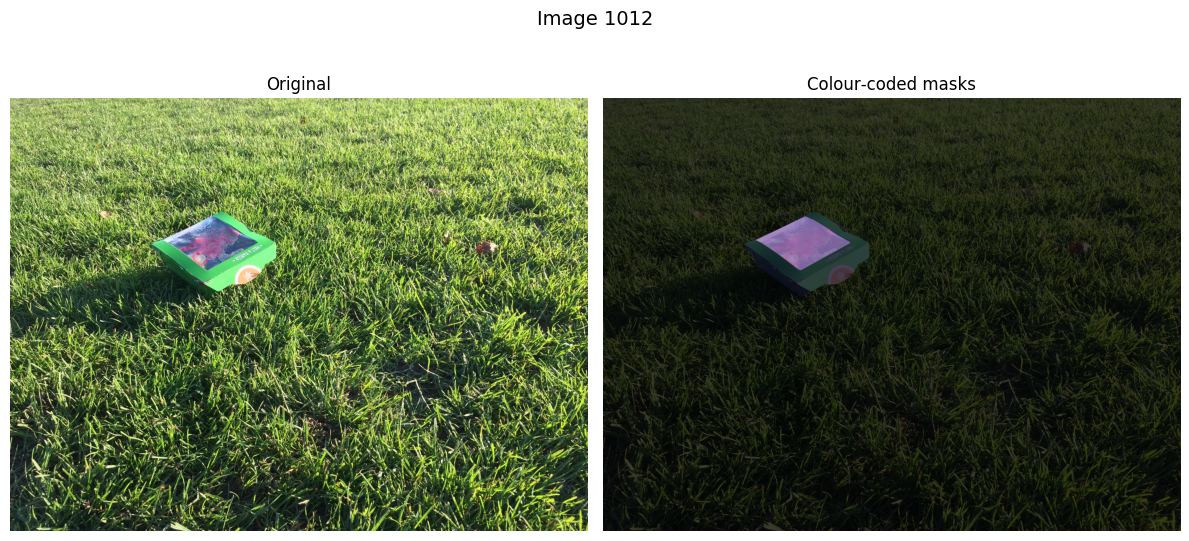


Image 1387 (batch_8/000087.jpg) has 1 masks:
  • Drink can (super: Can)


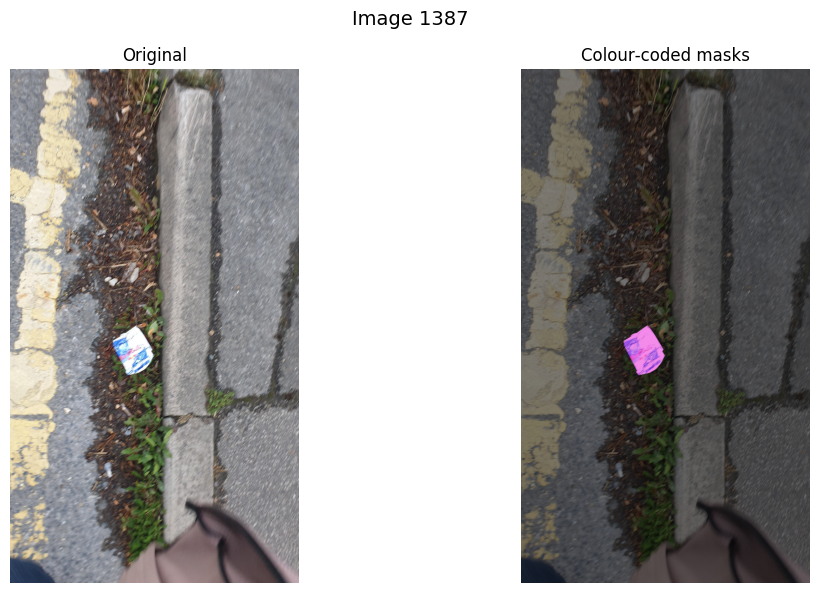


Image 791 (batch_3/IMG_5040.JPG) has 1 masks:
  • Crisp packet (super: Plastic bag & wrapper)


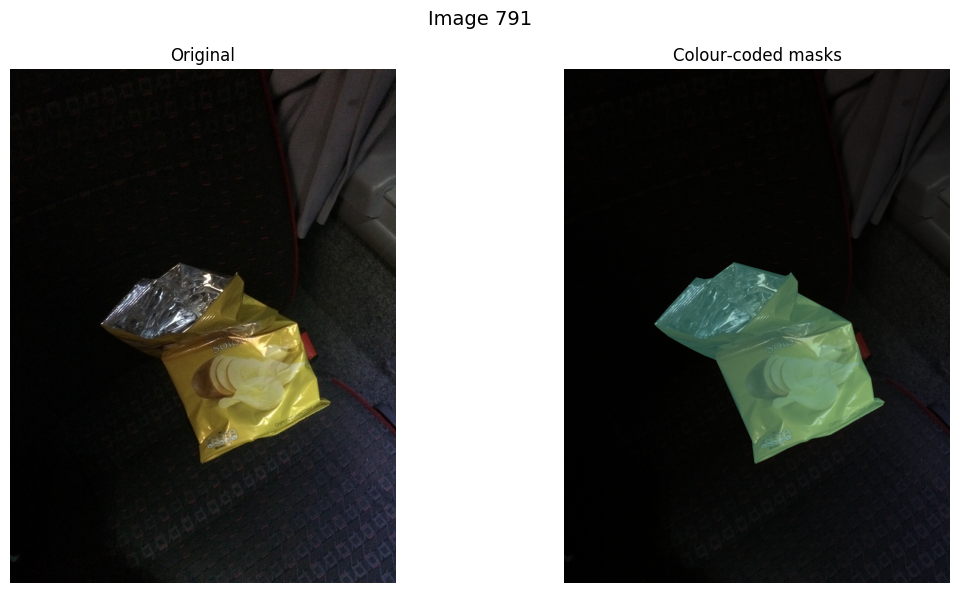

In [20]:
ann_file    = os.path.join(dataset_dir, 'annotations_train.json')
coco        = COCO(ann_file)
img_ids     = coco.getImgIds()[:3]

for img_id in img_ids:
    # --- load image + anns ---
    img = coco.loadImgs(img_id)[0]
    I   = Image.open(os.path.join(dataset_dir, img['file_name']))
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    anns    = coco.loadAnns(ann_ids)

    # --- print how many + their categories ---
    print(f"\nImage {img_id} ({img['file_name']}) has {len(anns)} masks:")
    for a in anns:
        cat = coco.loadCats(a['category_id'])[0]
        print(f"  • {cat['name']} (super: {cat['supercategory']})")

    # --- set up figure ---
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    fig.suptitle(f"Image {img_id}", fontsize=14)

    ax1.imshow(I)
    ax1.set_title("Original")
    ax1.axis('off')

    ax2.imshow(I)
    ax2.set_title("Colour‑coded masks")
    ax2.axis('off')

    # --- overlay each mask in its own random colour ---
    for ann in anns:
        mask = coco.annToMask(ann)  # H×W binary
        color = (random.random(), random.random(), random.random())
        # make a H×W×3 RGB mask
        rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)
        for c in range(3):
            rgb_mask[...,c] = mask * color[c]
        ax2.imshow(rgb_mask, alpha=0.5)

    plt.tight_layout()
    plt.show()

Total masks in dataset: 4784
Number of categories   : 59


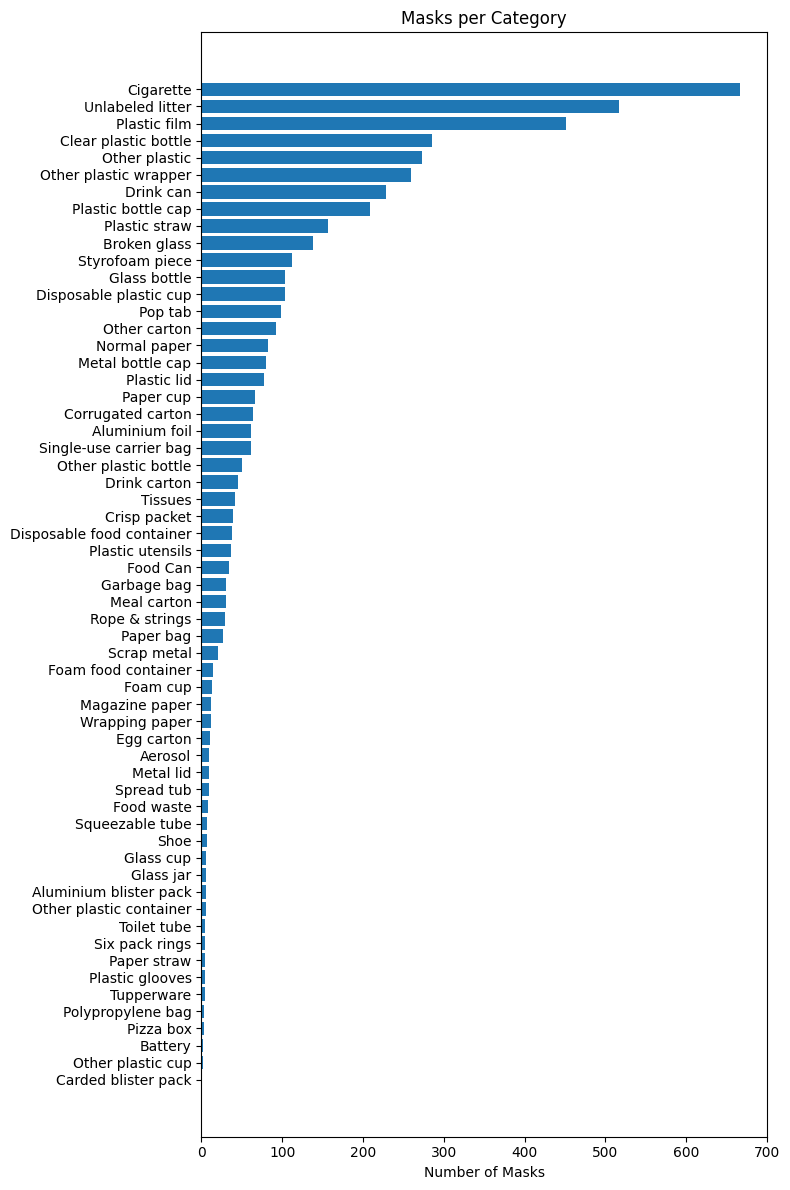

In [28]:
# === CONFIGURE THIS ===
ann_file    = os.path.join(dataset_dir, 'annotations.json')

# 1. Load your annotations
with open(ann_file, 'r') as f:
    data = json.load(f)

# 2. Build a lookup for categories
cats = {c['id']: c for c in data['categories']}

# 3. Count up masks per category
cat_counts = Counter()
for ann in data['annotations']:
    cat_counts[cats[ann['category_id']]['name']] += 1

# sort descending
cat_items = sorted(cat_counts.items(), key=lambda x: x[1], reverse=True)
names, counts = zip(*cat_items)

# 3a. Print total masks and number of distinct categories
total_masks      = sum(counts)
num_categories   = len(names)
print(f"Total masks in dataset: {total_masks}")
print(f"Number of categories   : {num_categories}")

In [ ]:
# 4. Plot horizontal bar chart
plt.figure(figsize=(8, 12))
plt.barh(names, counts)
plt.gca().invert_yaxis()   # largest at the top
plt.xlabel("Number of Masks")
plt.title("Masks per Category")
plt.tight_layout()
plt.show()

Total masks in dataset      : 4784
Number of supercategories   : 28



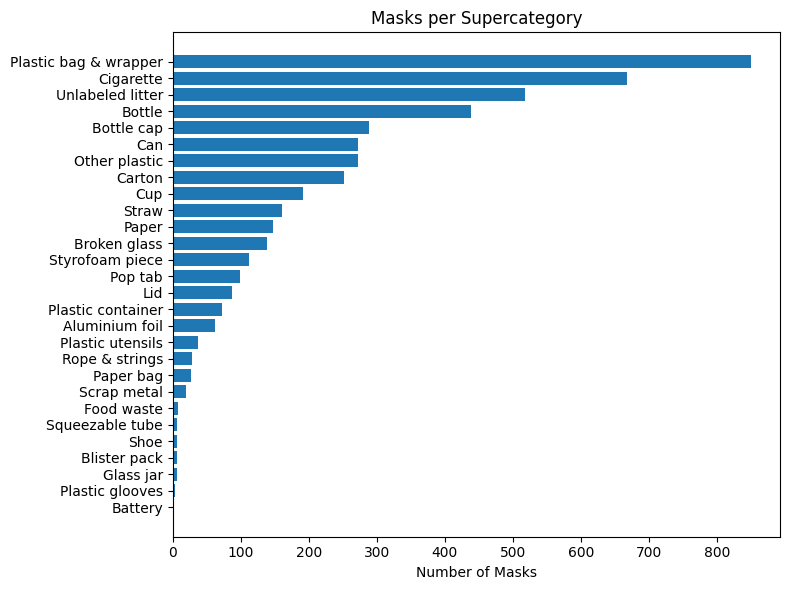

In [29]:
# === CONFIGURE THIS ===
ann_file    = os.path.join(dataset_dir, 'annotations.json')

# 1. Load your annotations
with open(ann_file, 'r') as f:
    data = json.load(f)

# 2. Build a lookup for categories
cats = {c['id']: c for c in data['categories']}

# 3. Count up masks per supercategory
super_counts = Counter()
for ann in data['annotations']:
    supercat = cats[ann['category_id']]['supercategory']
    super_counts[supercat] += 1

# 3a. Sort descending
items = sorted(super_counts.items(), key=lambda x: x[1], reverse=True)
names, counts = zip(*items)

# 3b. Print totals
total_masks        = sum(counts)
num_supercats      = len(names)
print(f"Total masks in dataset      : {total_masks}")
print(f"Number of supercategories   : {num_supercats}\n")

In [ ]:
# 4. Plot horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(names, counts)
plt.gca().invert_yaxis()    # largest at the top
plt.xlabel("Number of Masks")
plt.title("Masks per Supercategory")
plt.tight_layout()
plt.show()

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as F

def clip_boxes_to_image(boxes, img_w, img_h):
    clipped = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        x_min = max(0, min(x_min, img_w - 1))
        y_min = max(0, min(y_min, img_h - 1))
        x_max = max(0, min(x_max, img_w - 1))
        y_max = max(0, min(y_max, img_h - 1))
        clipped.append([x_min, y_min, x_max, y_max])
    return clipped

class TacoDataset(Dataset):
    def __init__(self, images_dir, annotation_path, transforms=None, max_resolution=(4000, 4000)):
        self.images_dir = images_dir
        self.coco = COCO(annotation_path)
        self.transforms = transforms
        self.max_resolution = max_resolution
        self.image_ids = [img_id for img_id in self.coco.imgs
                          if self.coco.imgs[img_id]['width'] <= max_resolution[0] and
                             self.coco.imgs[img_id]['height'] <= max_resolution[1]]
        print(f"✅ Loaded {len(self.image_ids)} images under resolution {max_resolution}")

    def __getitem__(self, index):
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        image = np.array(Image.open(img_path).convert("RGB"))
        img_h, img_w = image.shape[:2]

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels, masks = [], [], []
        for ann in anns:
            x, y, w, h = ann['bbox']
            x_min, y_min = x, y
            x_max, y_max = x + w, y + h
            if x_max <= x_min or y_max <= y_min:
                continue
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann['category_id'])
            masks.append(self.coco.annToMask(ann))

        boxes = clip_boxes_to_image(boxes, img_w, img_h)

        resized_masks = []
        for m in masks:
            if m.shape != (img_h, img_w):
                m_img = Image.fromarray(m.astype(np.uint8))
                m_resized = F.resize(m_img, (img_h, img_w), interpolation=Image.NEAREST)
                m = np.array(m_resized)
            resized_masks.append(m)

        if not boxes:
            boxes = [[0, 0, 1, 1]]
            labels = [0]
            resized_masks = [np.zeros((img_h, img_w), dtype=np.uint8)]

        if self.transforms:
            try:
                transformed = self.transforms(
                    image=image,
                    masks=resized_masks,
                    bboxes=boxes,
                    category_ids=labels
                )

                valid_boxes, valid_labels, valid_masks = [], [], []
                for i, box in enumerate(transformed["bboxes"]):
                    x_min, y_min, x_max, y_max = box
                    if (x_max - x_min) > 1 and (y_max - y_min) > 1:
                        valid_boxes.append(box)
                        valid_labels.append(transformed["category_ids"][i])
                        valid_masks.append(transformed["masks"][i])

                if not valid_boxes:
                    h, w = transformed["image"].shape[1:]
                    valid_boxes = [[0, 0, 1, 1]]
                    valid_labels = [0]
                    valid_masks = [np.zeros((h, w), dtype=np.uint8)]

                image = transformed['image'].float() / 255.0
                boxes = torch.as_tensor(valid_boxes, dtype=torch.float32)
                labels = torch.as_tensor(valid_labels, dtype=torch.int64)
                masks = torch.stack([torch.tensor(m, dtype=torch.uint8) for m in valid_masks])

            except Exception as e:
                print(f"⚠️ Transform failed on image_id {img_id} with error: {e}")
                image = F.to_tensor(Image.fromarray(image))
            
                # Filter invalid boxes again (even after failed transform)
                final_boxes, final_labels, final_masks = [], [], []
                for i, box in enumerate(boxes):
                    x_min, y_min, x_max, y_max = box
                    if (x_max - x_min) > 1 and (y_max - y_min) > 1:
                        final_boxes.append(box)
                        final_labels.append(labels[i])
                        final_masks.append(resized_masks[i])
            
                if not final_boxes:
                    final_boxes = [[0, 0, 1, 1]]
                    final_labels = [0]
                    final_masks = [np.zeros((img_h, img_w), dtype=np.uint8)]

                boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
                labels = torch.as_tensor(final_labels, dtype=torch.int64)
                masks = torch.stack([torch.tensor(m, dtype=torch.uint8) for m in final_masks])

        else:
            image = F.to_tensor(Image.fromarray(image))
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.stack(resized_masks), dtype=torch.uint8)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id]),
            'area': torch.as_tensor([ann['area'] for ann in anns], dtype=torch.float32),
            'iscrowd': torch.as_tensor([ann.get('iscrowd', 0) for ann in anns], dtype=torch.int64)
        }

        return image, target

    def __len__(self):
        return len(self.image_ids)

/home/venkatesh/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ New augmentations using Detectron2-style (simple and robust)
def get_train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))


def get_val_transform():
    return A.Compose([
        A.Resize(512, 512),
        ToTensorV2()
    ])

# Dataset & DataLoader setup
train_dataset = TacoDataset(
    images_dir='data',
    annotation_path='data/annotations_train.json',
    transforms=get_train_transform()
)

val_dataset = TacoDataset(
    images_dir='data',
    annotation_path='data/annotations_val.json',
    transforms=get_val_transform()
)

test_dataset = TacoDataset(
    images_dir='data',
    annotation_path='data/annotations_test.json',
    transforms=get_val_transform()
)

def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"\nTrain: {len(train_dataset)} images")
print(f"Val:   {len(val_dataset)} images")
print(f"Test:  {len(test_dataset)} images")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
✅ Loaded 839 images under resolution (4000, 4000)
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
✅ Loaded 119 images under resolution (4000, 4000)
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
✅ Loaded 105 images under resolution (4000, 4000)

📦 Train: 839 images
📦 Val:   119 images
📦 Test:  105 images


In [ ]:
def show_image_with_boxes_masks(image, boxes, masks, title=""):
    img = image.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    for mask in masks:
        img[mask > 0] = img[mask > 0] * 0.5 + np.array([255, 0, 0]) * 0.5  # overlay red mask

    plt.figure(figsize=(8,8))
    plt.imshow(img.astype(np.uint8))
    plt.title(title)
    plt.axis("off")
    plt.show()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
✅ Loaded 839 images under resolution (4000, 4000)


/tmp/ipykernel_10309/1467205086.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.stack([torch.tensor(m, dtype=torch.uint8) for m in valid_masks])


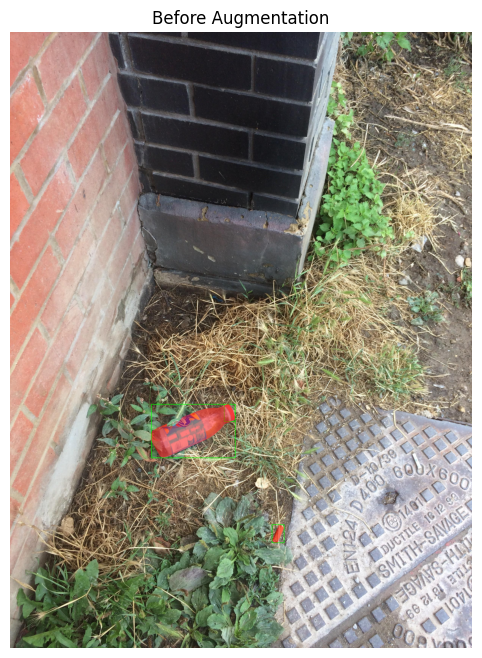

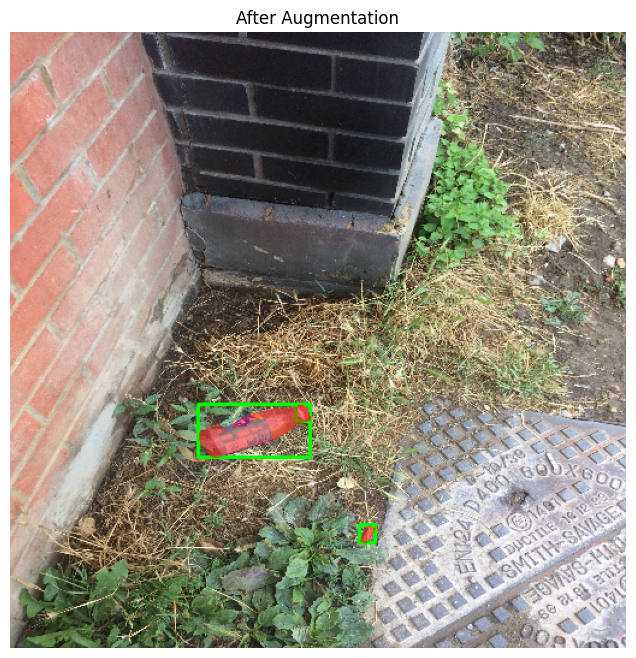

In [3]:
# Pick a random image
index = random.randint(0, len(train_dataset) - 1)

# Load without transform
original = TacoDataset(
    images_dir='data',
    annotation_path='data/annotations_train.json',
    transforms=None
)[index]

orig_img = original[0].permute(1, 2, 0).numpy() * 255
orig_boxes = original[1]['boxes'].numpy()
orig_masks = original[1]['masks'].numpy()

# Load with transform
augmented = train_dataset[index]
aug_img = augmented[0].permute(1, 2, 0).numpy() * 255
aug_boxes = augmented[1]['boxes'].numpy()
aug_masks = augmented[1]['masks'].numpy()

In [ ]:
# Show before
show_image_with_boxes_masks(orig_img, orig_boxes, orig_masks, title="Before Augmentation")

# Show after
show_image_with_boxes_masks(aug_img, aug_boxes, aug_masks, title="After Augmentation")

In [4]:
for imgs, targets in train_loader:
    print("Batch size:", len(imgs))
    print("1st image shape:", imgs[0])
    print("1st target keys:", targets[0].keys())
    print("1st target values:", targets[0].values())
    break

Batch size: 1
1st image shape: tensor([[[0.7373, 0.7529, 0.7765,  ..., 0.7569, 0.8039, 0.8235],
         [0.7608, 0.7961, 0.7608,  ..., 0.7882, 0.7608, 0.6863],
         [0.7490, 0.7961, 0.7961,  ..., 0.7765, 0.8392, 0.8275],
         ...,
         [0.7137, 0.6353, 0.7020,  ..., 0.7216, 0.4000, 0.3333],
         [0.6941, 0.7020, 0.5333,  ..., 0.3647, 0.2784, 0.6902],
         [0.7725, 0.4549, 0.4235,  ..., 0.4902, 0.6196, 0.7608]],

        [[0.6863, 0.6980, 0.7176,  ..., 0.7412, 0.8157, 0.8824],
         [0.7176, 0.7490, 0.7098,  ..., 0.7725, 0.7490, 0.6667],
         [0.7059, 0.7569, 0.7490,  ..., 0.7529, 0.8118, 0.7961],
         ...,
         [0.7922, 0.7059, 0.7843,  ..., 0.6863, 0.3922, 0.3059],
         [0.7882, 0.7765, 0.6235,  ..., 0.3569, 0.3098, 0.7255],
         [0.8706, 0.5373, 0.4980,  ..., 0.5176, 0.7020, 0.8039]],

        [[0.5608, 0.5961, 0.6235,  ..., 0.6157, 0.7333, 0.8039],
         [0.6157, 0.6471, 0.6118,  ..., 0.7137, 0.6902, 0.5882],
         [0.6314, 0.6588, 0

/tmp/ipykernel_10309/1467205086.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.stack([torch.tensor(m, dtype=torch.uint8) for m in valid_masks])


In [5]:
# --- Create the Mask R-CNN model ---
def get_model(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)

    # Replace box head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace mask head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
    
    return model

In [6]:
# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background
model = get_model(num_classes).to(device)

print(f'Model is on device: {device}')

/home/venkatesh/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/venkatesh/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer = optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.005, # 0.001, 0.005, 0.0001
    momentum=0.9,
    weight_decay=0.0005)

# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=16)

In [6]:
# from skimage import measure

# def binary_mask_to_polygon(mask, tolerance=2):
#     if mask.shape[0] < 2 or mask.shape[1] < 2:
#         print(f"⚠️ Skipping too-small mask with shape: {mask.shape}")
#         return []  # Skip invalid masks

#     contours = measure.find_contours(mask, 0.5)
#     segmentations = []

#     for contour in contours:
#         contour = np.flip(contour, axis=1)  # (y,x) → (x,y)
#         segmentation = contour.ravel().tolist()
#         if len(segmentation) >= 6:  # must have at least 3 points
#             segmentations.append(segmentation)

#     return segmentations

In [7]:
# from pycocotools.cocoeval import COCOeval
# import numpy as np

# def evaluate_model(model, data_loader, coco_gt, device, coco_category_ids):
#     model.eval()
#     coco_results = []

#     with torch.no_grad():
#         for images, targets in data_loader:
#             images = [img.to(device) for img in images]
#             outputs = model(images)

#             for i, output in enumerate(outputs):
#                 img_id = int(targets[i]["image_id"].item())
#                 boxes = output["boxes"].detach().cpu().numpy()
#                 scores = output["scores"].detach().cpu().numpy()
#                 labels = output["labels"].detach().cpu().numpy()
#                 masks = output["masks"].detach().cpu().numpy()[:, 0, :, :] 

#                 for j in range(len(boxes)):
#                     # if scores[j] < 0.05:
#                     #     continue

#                     x1, y1, x2, y2 = boxes[j]
#                     if x2 <= x1 or y2 <= y1:
#                         continue

#                     polygons = binary_mask_to_polygon(masks[j])
#                     if not polygons:
#                         continue

#                     coco_results.append({
#                         "image_id": img_id,
#                         "category_id": int(coco_category_ids.get(labels[j], labels[j])),  # map label
#                         "bbox": [x1, y1, x2 - x1, y2 - y1],
#                         "score": 1.0,
#                         "segmentation": polygons
#                     })

#     if not coco_results:
#         print("⚠️ No valid predictions to evaluate.")
#         return

#     coco_dt = coco_gt.loadRes(coco_results)
#     coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')
#     coco_eval.evaluate()
#     coco_eval.accumulate()
#     coco_eval.summarize()


In [7]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

In [8]:
def evaluate_segmentation_metrics(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    all_ious = []
    true_positives, false_positives, false_negatives = 0, 0, 0
    cls_correct, cls_total = 0, 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            outputs = [{k: v.cpu() for k, v in out.items()} for out in outputs]

            torch.cuda.empty_cache()

            for i in range(len(images)):
                gt_masks = targets[i]['masks'].cpu().numpy().astype(bool)
                gt_labels = targets[i]['labels'].cpu().numpy()
                pred_masks = outputs[i]['masks'].numpy() > 0.5
                pred_masks = pred_masks[:, 0, :, :]
                pred_labels = outputs[i]['labels'].numpy()

                matched_gt = set()
                matched_pred = set()

                for gi, (gt, gt_cls) in enumerate(zip(gt_masks, gt_labels)):
                    best_iou = 0
                    best_pi = -1
                    for pi, (pred, pred_cls) in enumerate(zip(pred_masks, pred_labels)):
                        if pred_cls != gt_cls:
                            continue  # only match masks of same category
                        iou = calculate_iou(gt, pred)
                        if iou > best_iou:
                            best_iou = iou
                            best_pi = pi

                    if best_iou >= iou_threshold:
                        matched_gt.add(gi)
                        matched_pred.add(best_pi)
                        true_positives += 1
                        all_ious.append(best_iou)
                        # Classification accuracy
                        if pred_labels[best_pi] == gt_cls:
                            cls_correct += 1
                        cls_total += 1
                    else:
                        false_negatives += 1
                        cls_total += 1

                for pi in range(len(pred_masks)):
                    if pi not in matched_pred:
                        false_positives += 1
                        cls_total += 1

            del images, targets, outputs
            torch.cuda.empty_cache()

    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    mean_iou = np.mean(all_ious) if all_ious else 0.0
    cls_acc = cls_correct / (cls_total + 1e-6)

    return {
        "mean_iou": mean_iou,
        "precision": precision,
        "recall": recall,
        "cls_accuracy": cls_acc,
        "num_predictions": true_positives + false_positives,
        "num_ground_truth": true_positives + false_negatives,
    }

In [9]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, lr_scheduler, device, num_epochs=10, print_interval=20):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        print(f"\n\U0001F680 Starting Epoch {epoch+1}/{num_epochs} at {datetime.now().strftime('%H:%M:%S')}")

        for step, (images, targets) in enumerate(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            try:
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"\u26A0\ufe0f Invalid loss at step {step+1}, skipping")
                    continue

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            except RuntimeError as e:
                print(f"\u274C CUDA error at step {step+1}: {e}")
                torch.cuda.empty_cache()
                continue

            if (step + 1) % print_interval == 0 or (step + 1) == len(train_loader):
                print(f"  \U0001F501 Step {step+1}/{len(train_loader)} — Batch Loss: {loss.item():.4f}")

            del images, targets
            torch.cuda.empty_cache()

        lr_scheduler.step()
        avg_loss = total_loss / len(train_loader)
        print(f"\n\U0001F4D8 Epoch {epoch+1} — Average Epoch Loss: {avg_loss:.4f}")
        if epoch%2==0:
            for name, loader in [("train", train_loader), ("val", val_loader)]:
                print(f"\n\U0001F50D Evaluating on {name} set...")
                try:
                    metrics = evaluate_segmentation_metrics(model, loader, device)
                    print(f"\U0001F4CF {name.upper()} → IoU: {metrics['mean_iou']:.4f} | "
                          f"Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | "
                          f"Class Acc: {metrics['cls_accuracy']:.4f}")
                except Exception as e:
                    print(f"\u274C Evaluation failed on {name}: {e}")

    print("\n\U0001F50D Final Evaluation on TEST set...")
    metrics_test = evaluate_segmentation_metrics(model, test_loader, device)
    print(f"\U0001F4CF TEST → IoU: {metrics_test['mean_iou']:.4f} | "
          f"Precision: {metrics_test['precision']:.4f} | Recall: {metrics_test['recall']:.4f} | "
          f"Class Acc: {metrics_test['cls_accuracy']:.4f}")

    torch.save(model.state_dict(), "maskrcnn_taco_baseline.pth")
    print("\u2705 Model saved to maskrcnn_taco_baseline.pth")


In [ ]:
# train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, lr_scheduler, device, num_epochs=10, print_interval=40)


🚀 Starting Epoch 1/10 at 13:18:29


/tmp/ipykernel_10309/1467205086.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.stack([torch.tensor(m, dtype=torch.uint8) for m in valid_masks])
/home/venkatesh/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  🔁 Step 40/839 — Batch Loss: 2.0966
  🔁 Step 80/839 — Batch Loss: 1.3595
  🔁 Step 120/839 — Batch Loss: 2.0954
  🔁 Step 160/839 — Batch Loss: 1.5518
  🔁 Step 200/839 — Batch Loss: 1.1363


In [5]:
def evaluate_ground_truth_as_prediction(coco_gt):
    coco_results = []

    for img_id in coco_gt.getImgIds():
        anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
        for ann in anns:
            if 'segmentation' not in ann or 'bbox' not in ann or 'category_id' not in ann:
                continue

            # COCO format expects score when evaluating detections
            coco_results.append({
                "image_id": img_id,
                "category_id": ann["category_id"],
                "bbox": ann["bbox"],
                "score": 1.0,  # max confidence
                "segmentation": ann["segmentation"]
            })

    # Convert to COCO predictions format
    coco_dt = coco_gt.loadRes(coco_results)

    # Run evaluation
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

In [6]:
# evaluate_ground_truth_as_prediction(val_dataset.coco)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.61s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.982
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10